In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk

In [3]:
%matplotlib notebook

In [4]:
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [-0.2398, 0.1145]
tangential_distortion = [0, 0]

In [5]:
all_pmt_locations = fit.read_3d_feature_locations("SK_all_PMT_locations.txt")
image_feature_locations = {}
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_Labeled/B2370344.txt"))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_Labeled/B2380354.txt"))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_Labeled/B2390365.txt"))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_Labeled/B2400374.txt"))

<IPython.core.display.Javascript object>


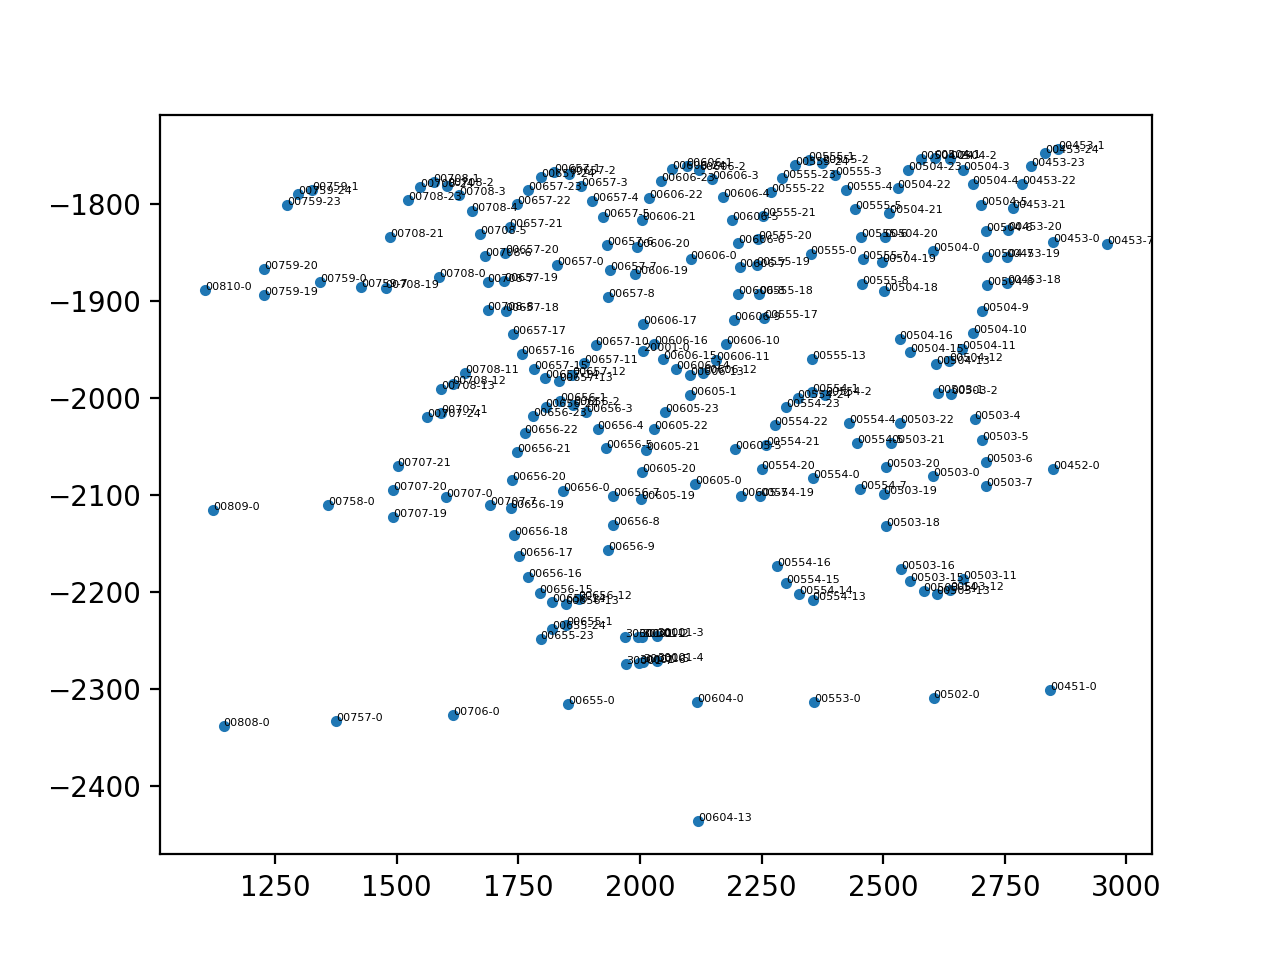

<IPython.core.display.Javascript object>


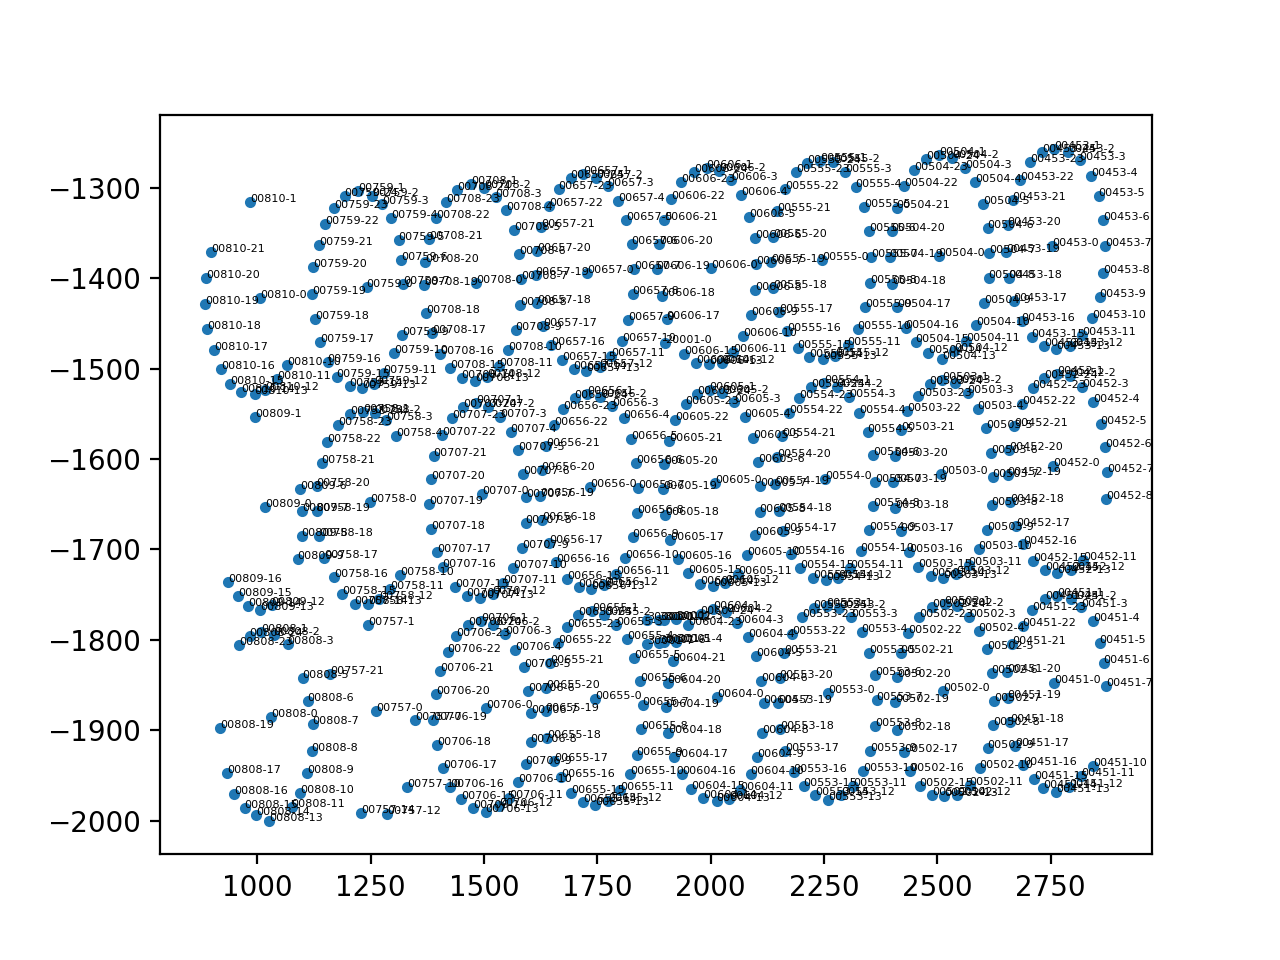

<IPython.core.display.Javascript object>


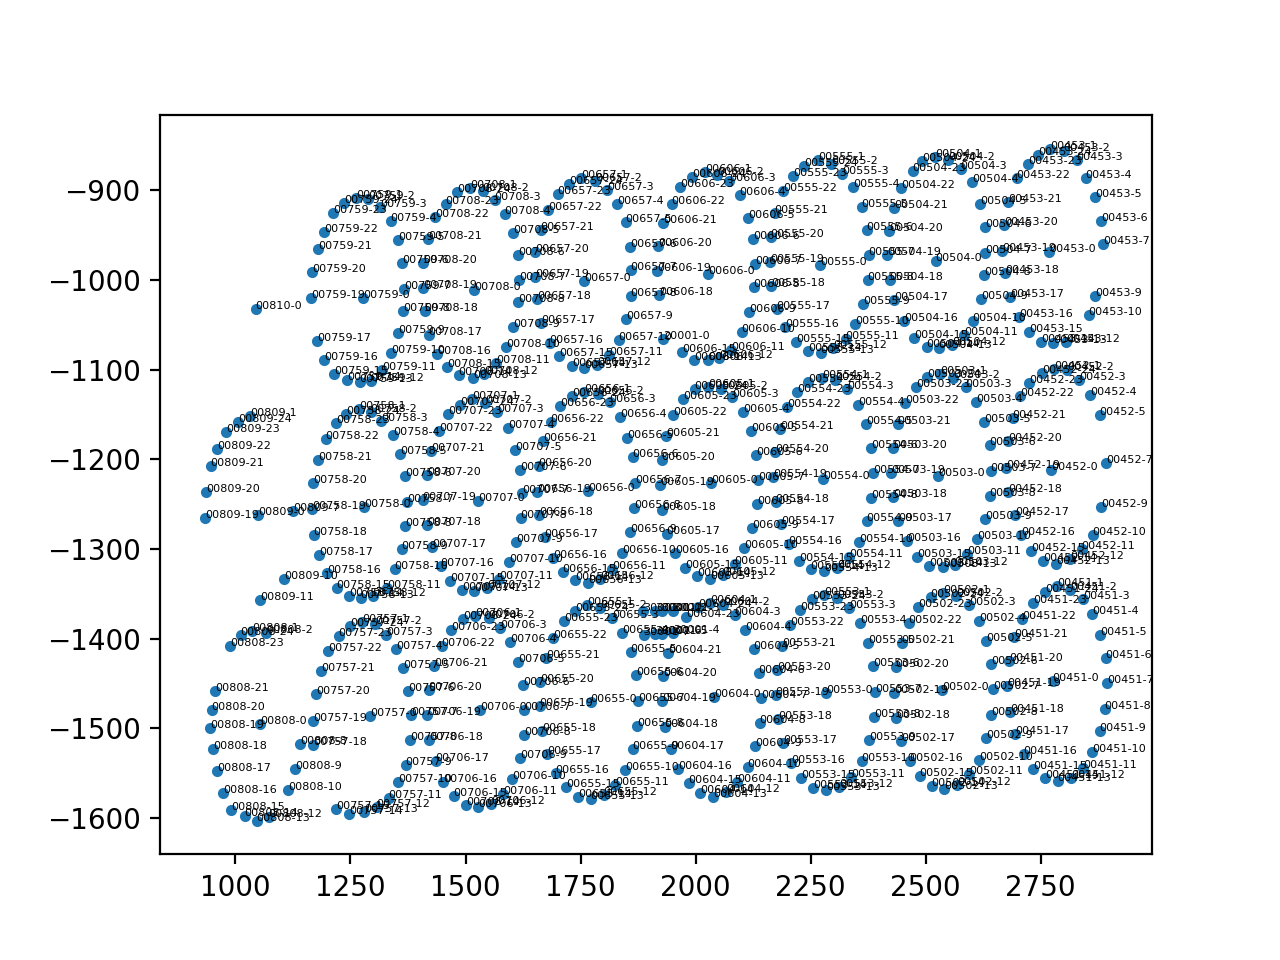

<IPython.core.display.Javascript object>


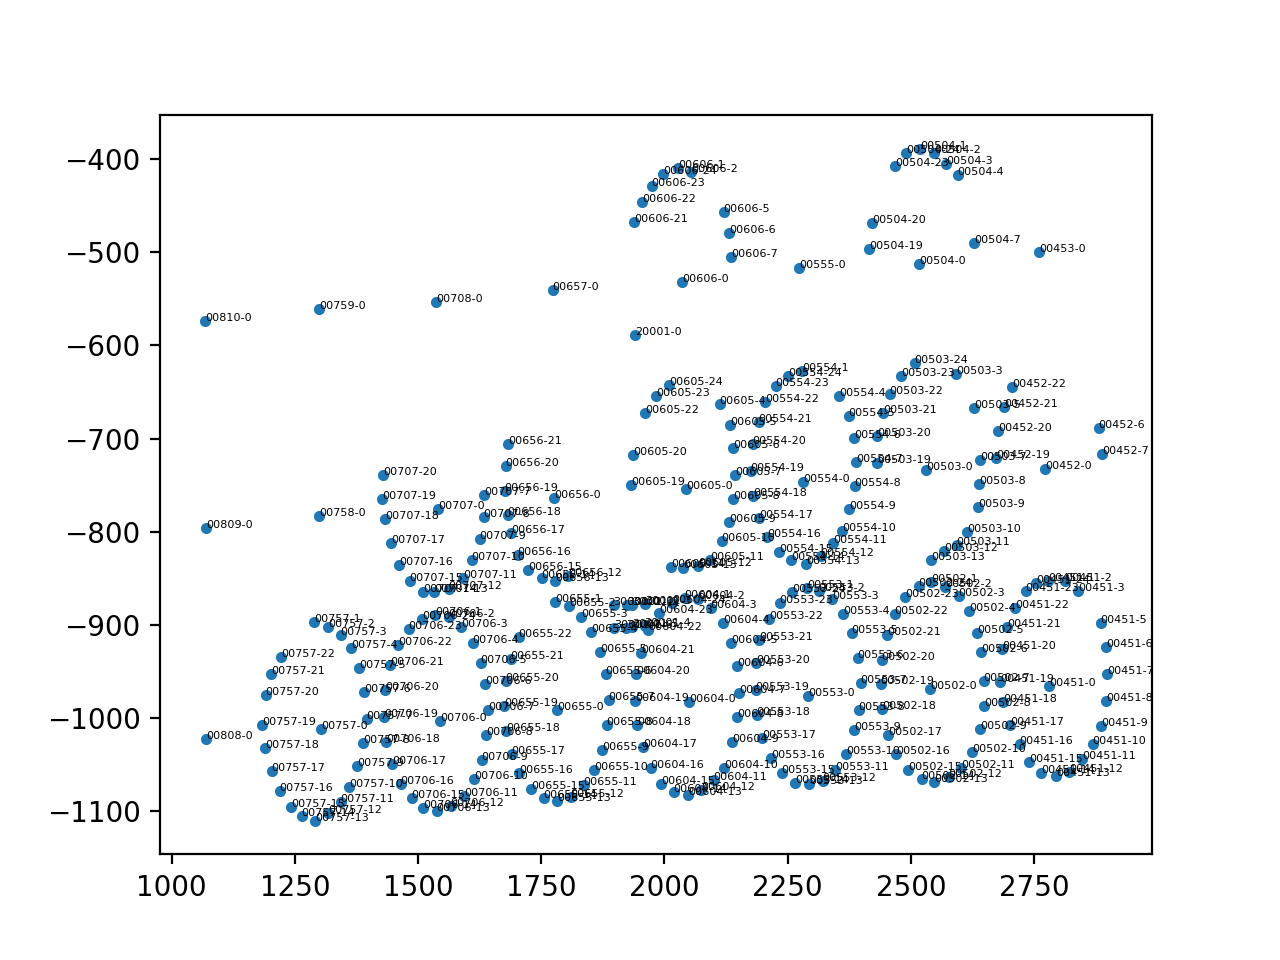

In [6]:
for i in image_feature_locations.values():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    coords = np.stack(list(i.values()))
    ax.scatter(coords[:,0], -coords[:,1], marker='.')
    for t, f in i.items():
        ax.text(f[0], -f[1], t, size=4, zorder=4, color='k') 

In [7]:
# choose features that appear in 2+ images
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)
#all_pmt_locations[common_features[10]]
#for k, i in image_feature_locations.items():
#    image_feature_locations[k] = {j: f for j, f in i.items() if j in common_features}
#pmt_locations = {k: v for k, v in pmt_locations.items() if k in common_features}

In [8]:
common_bolt_locations = {k: f for k, f in bolt_locations.items() if k in common_features}
common_feature_locations = {**pmt_locations, **common_bolt_locations}
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}
common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}
nimages = len(common_image_feature_locations)
nfeatures = len(common_feature_locations)
print(nimages, nfeatures)

4 525


<IPython.core.display.Javascript object>


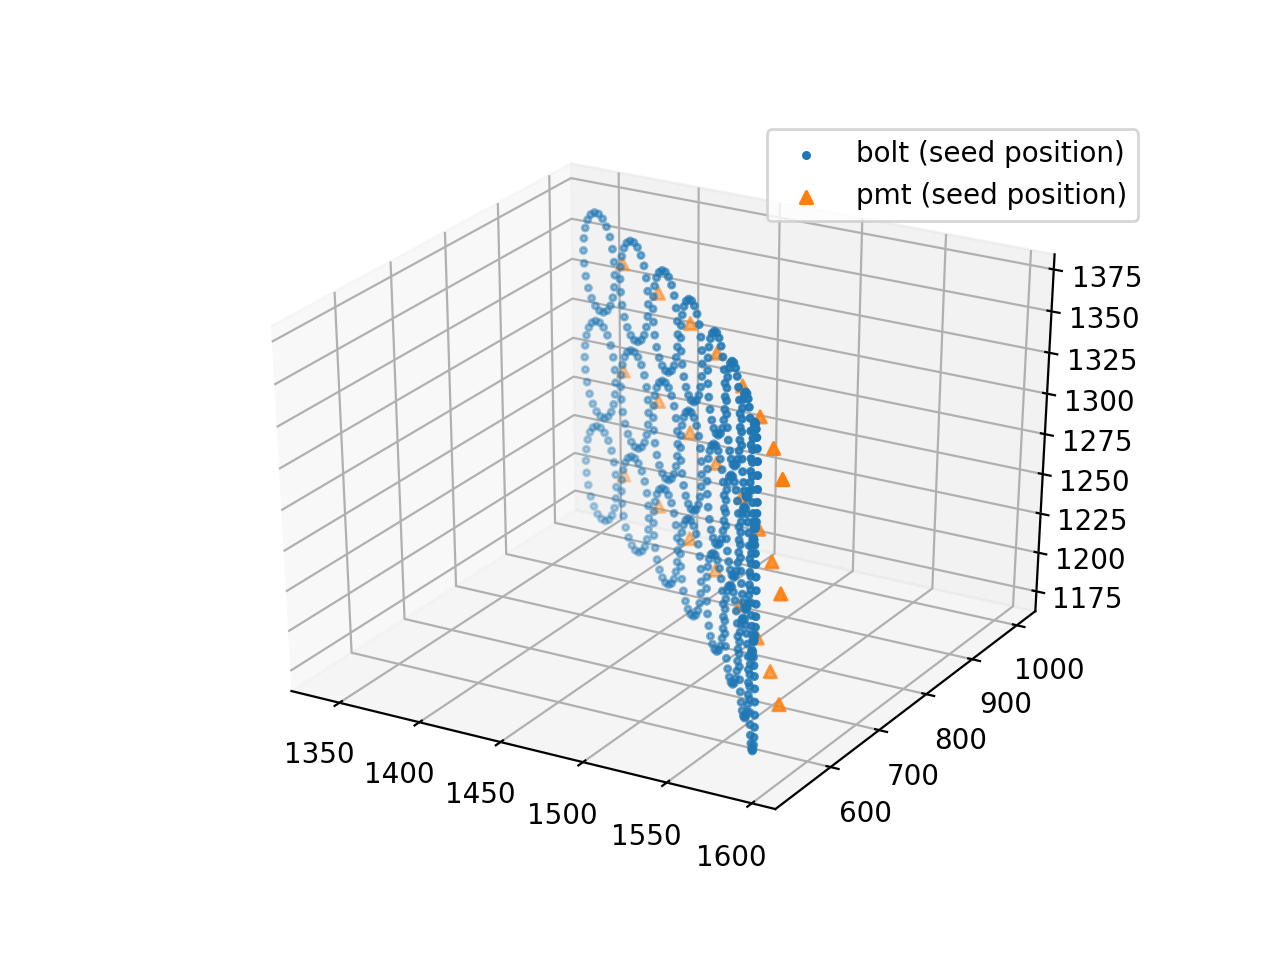

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


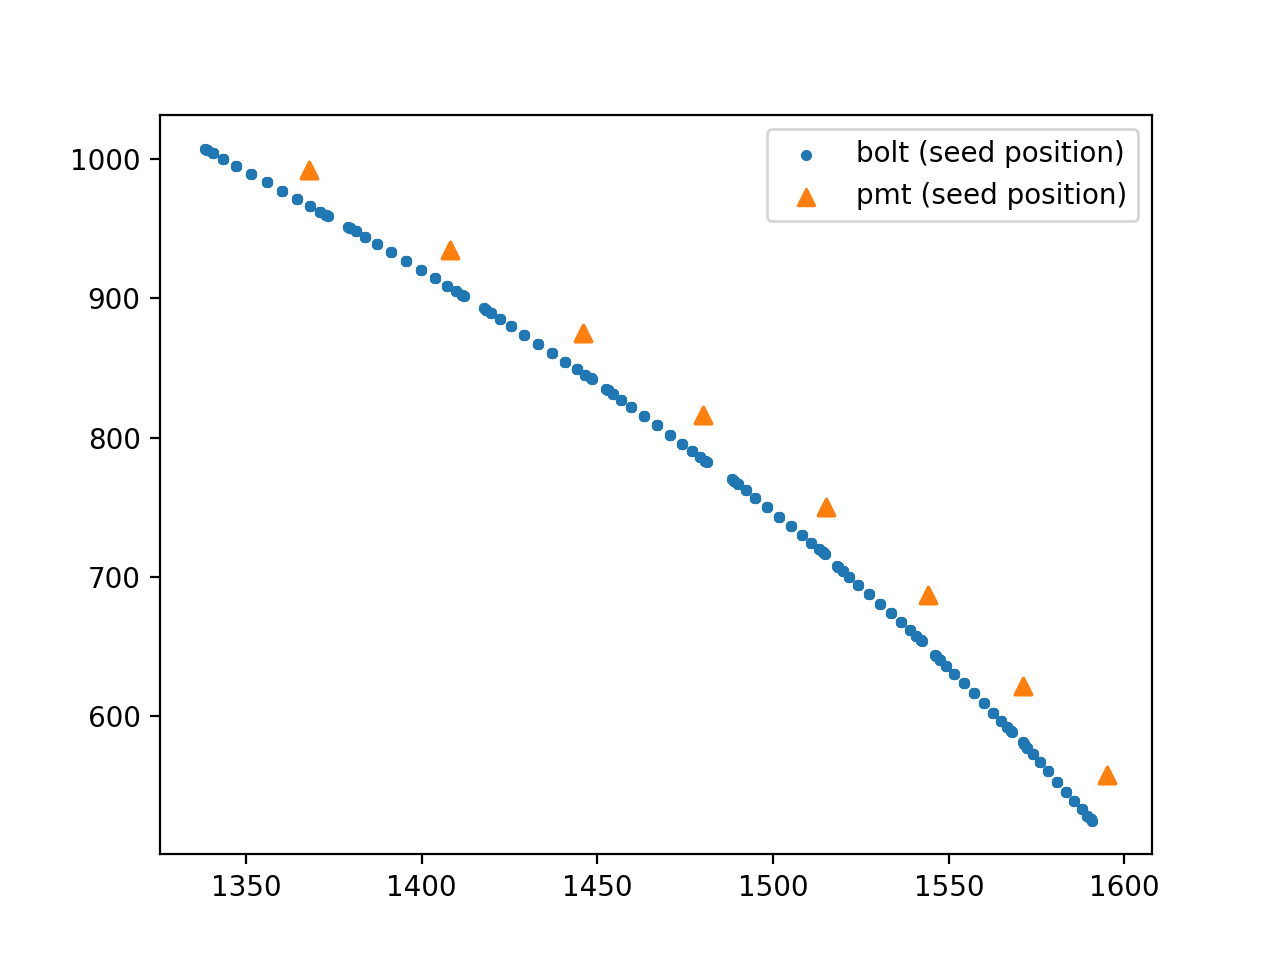

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
plt.legend(loc=0)

In [11]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, radial_distortion)

In [12]:
camera_rotations, camera_translations = fitter_pmts.estimate_camera_poses()

image 0 reprojection errors:    average: 3.209122578122855    max: 6.417147850623152
image 1 reprojection errors:    average: 3.3723786913740863    max: 7.265860897208645
image 2 reprojection errors:    average: 2.827522448687418    max: 5.745428890483345
image 3 reprojection errors:    average: 2.8259806410055313    max: 5.14965020657327


In [36]:
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(
    camera_rotations, camera_translations)

`ftol` termination condition is satisfied.
Function evaluations 9610, initial cost 1.2529e+06, final cost 1.3366e+03, first-order optimality 7.22e+00.
mean reprojection error: 1.0158732809940834
max reprojection error: 7.3256215105355


In [37]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 7.891990753137948
max reconstruction error: 18.50702319989704


In [38]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

<IPython.core.display.Javascript object>


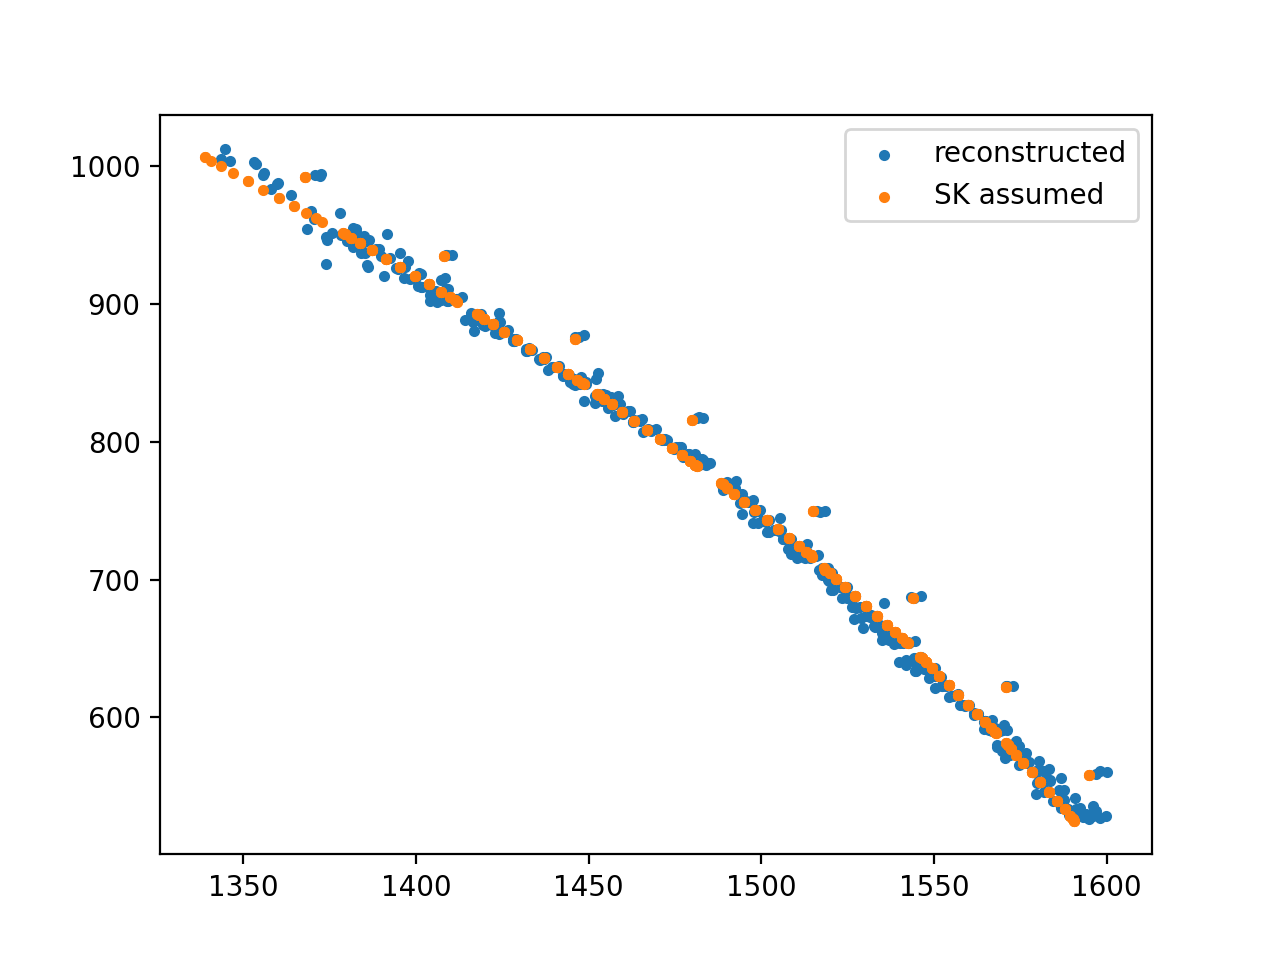

In [39]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], marker='.', label="reconstructed")
ax.scatter(true_array[:,0], true_array[:,1], marker='.', label="SK assumed")
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


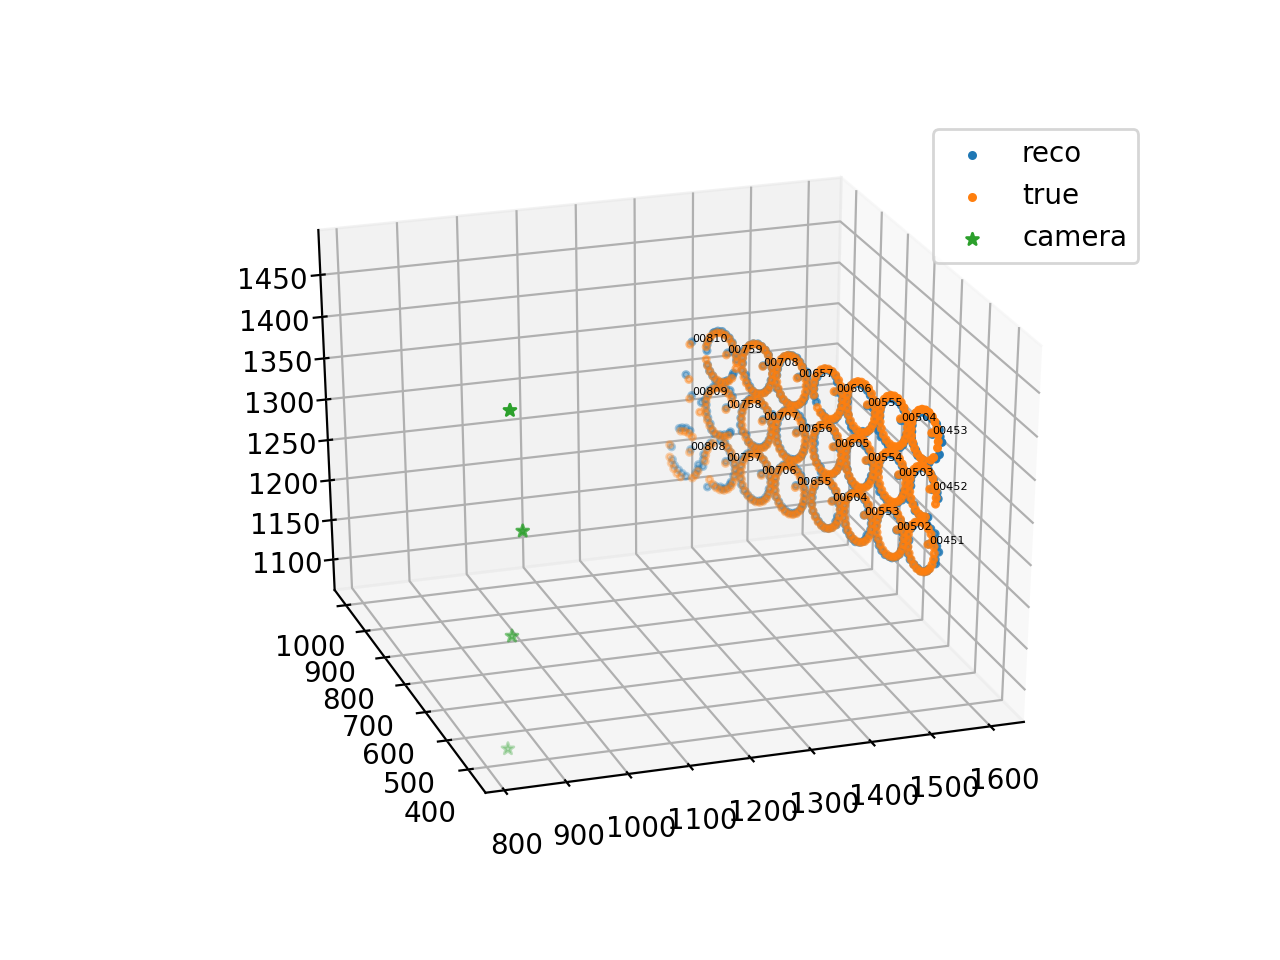

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)

<IPython.core.display.Javascript object>


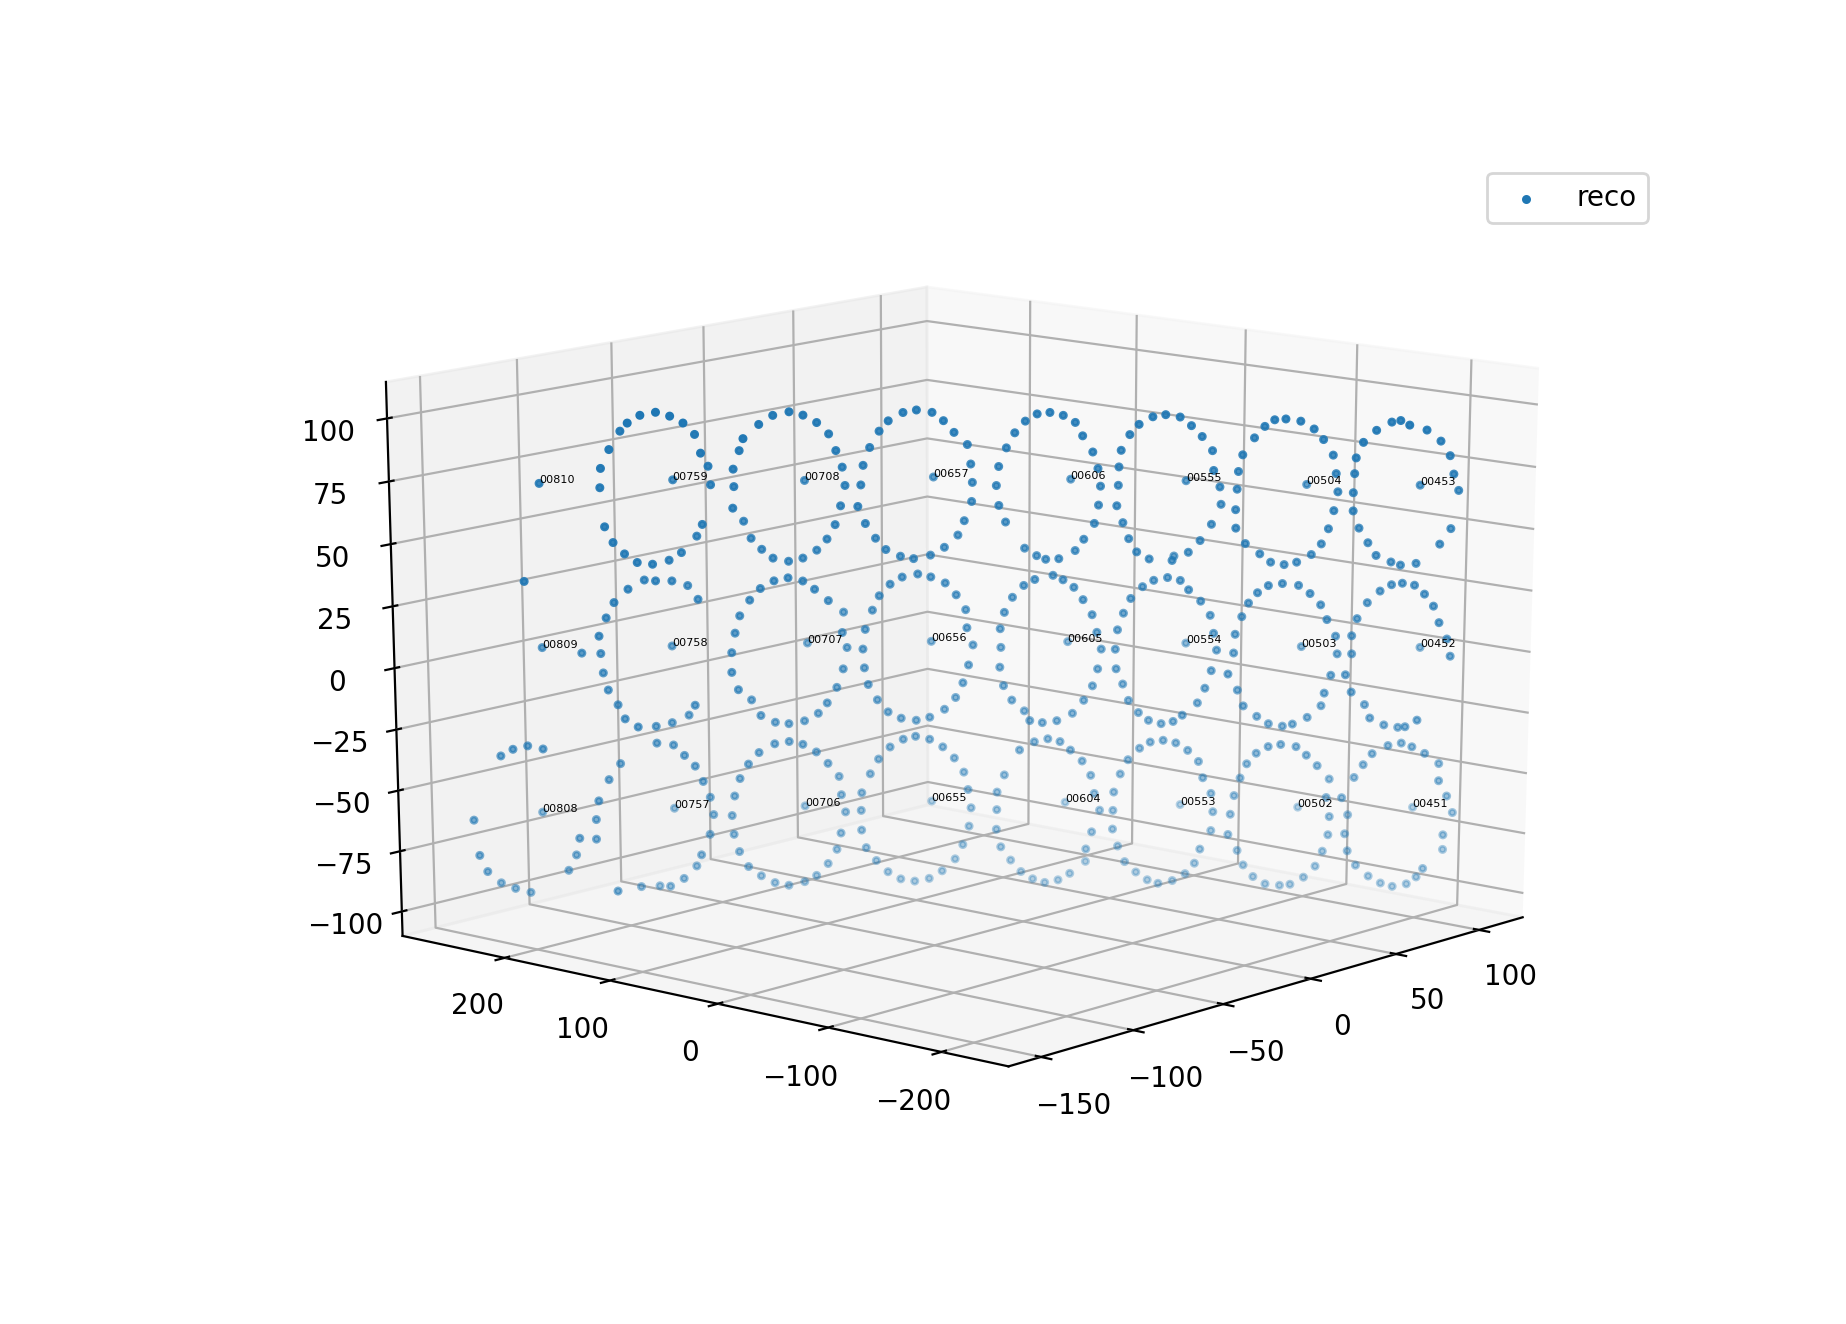

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco", zorder=3)
#ax.scatter(true_translated[:,0], true_translated[:,1], true_translated[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=4, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)

In [80]:
_ = plt.hist(linalg.norm(errors, axis=1), bins='auto')
plt.title("Reconstructed feature position error ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
plt.show()

In [32]:
a = np.zeros((3,4))
a[0,[1,2]] = 1
a

array([[0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [53]:
fitter_all.save_result("SK_demo1_features.txt", "SK_demo1_cameras.txt")

(525, 3)
